### Import packages

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as dates
import statsmodels.api as sm
import itertools
from pmdarima.arima import auto_arima
from math import sqrt
from sklearn.metrics import mean_squared_error
from pmdarima.arima.stationarity import ADFTest
import itertools
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import ndiffs
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import acf
import matplotlib.cm as cm
from scipy.fftpack import fft  
from scipy import signal
import warnings
warnings.filterwarnings("ignore")

### Function definition

In [77]:
def Plot_Time_Series(X, y, s , c):
    fig = plt.figure()
    plt.plot(X, y)
    plt.title(s+" "+ poi +" Changes at Wanhua, 2021")
    plt.xlabel('Time')
    plt.ylabel(poi+" index")
    fig.set_figheight(8)
    fig.set_figwidth(15)

    plt.plot(X,y, color=c)
    plt.show()

In [19]:
def OLS_Res(s, y):
    X = []
    for i in range(0, len(y)):
        X.append(i)
    reg = sm.OLS(y, X)
    result = reg.fit()
    # print result
    print(s+" OLS results: ")
    print("parameters: \n", result.params)
    print("\n", result.summary(),"\n","\n")

In [37]:
def EACF(arma, ar_max, ma_max, show):
    def lag1(arma, lag=1):
        return pd.Series(arma).shift(lag)
    
    def reupm(m, nrow, ncol):
        k = ncol - 1
        m2 = np.empty((m.shape[0], k))
        for i in range(k):
            i1 = i + 1
            work = lag1(m1[:, i])
            work[0] = -1
            temp = m1[:, i1] - work * m1[i1, i1]/m1[i, i]
            temp[i1] = 0
            m2[:, i] = temp
        return m2
    
    def ceascf(m, cov1, nar, ncol, count, ncov, arma, armam):
        result = np.zeros(nar+1)
        result[0] = cov1[ncov + count - 1]
        for i in range(1, nar+1):
            A = np.empty((len(arma) - i, i+1))
            A[:, 0] = arma[i:]
            A[:, 1:] = armam[i:, :i]
            b = np.r_[1, -m[:i, i-1]]
            temp = A @ b
            result[i] = acf(temp, nlags=count, fft=False)[count]
        return result
    
    ar_max = ar_max + 1
    ma_max = ma_max + 1
    nar = ar_max - 1
    nma = ma_max
    ncov = nar + nma + 2
    nrow = nar + nma + 1
    ncol = nrow - 1
    arma = np.array(arma) - np.mean(arma)
    armam = np.empty((len(arma), nar))
    for i in range(nar):
        armam[:, i] = lag1(arma, lag=i+1)
    cov1 = acf(arma, nlags=ncov, fft=False)
    cov1 = np.r_[np.flip(cov1[1:]), cov1]
    ncov = ncov + 1
    m1 = np.zeros((nrow, ncol))
    for i in range(ncol):
        m1[:i+1, i] = AutoReg(arma, lags=i+1, trend='c').fit().params[1:]
        
    eacf = np.empty((ar_max, nma))
    for i in range(nma):
        m2 = reupm(m = m1, nrow = nrow, ncol = ncol)
        ncol = ncol - 1
        eacf[:, i] = ceascf(m2, cov1, nar, ncol, i+1, ncov, arma, armam)
        m1 = m2
    
    work = np.arange(1, nar+2)
    work = len(arma) - work + 1
    symbol = np.empty(eacf.shape, dtype=object)
    for i in range(nma):
        work = work - 1
        symbol[:, i] = np.where(np.abs(eacf[:, i]) > 2/np.sqrt(work), 'x', 'o')
    
    symbol = pd.DataFrame(symbol)
    if show:
        print('AR / MA')
        print(symbol)
    
    return {
        'eacf': eacf,
        'ar.max': ar_max,
        'ma.max': ma_max,
        'symbol': symbol
    }

In [61]:
def STFT(df):
    cmap = cm.Purples
    f, t, Zxx = signal.stft(df.tolist(), fs=1)
    plt.figure(figsize=(8,8))
    plt.xlabel("time")
    plt.ylabel("frequence")
    plt.pcolormesh(t, f, np.abs(Zxx), cmap=cmap)    
    plt.title("STFT for " + df.name)
    plt.show()

In [71]:
def FFT(df): 
    #https://www.itread01.com/article/1532154074.html
    y = df.tolist()
    yy=fft(y)      #快速傅立葉變換
    
    yf=abs(yy)    # 取絕對值
    yf1=abs(yy)/len(y)   #歸一化處理
    yf2 = yf1[range(int(len(y)/2))] #由於對稱性，只取一半區間
    
    xf = np.arange(len(y))  # 頻率
    xf1 = xf
    xf2 = xf[range(int(len(y)/2))] #取一半區間        
    
    figure, axes = plt.subplots(nrows=2, ncols=2,figsize=(20,5))
    figure.tight_layout(pad=5)
    
    plt.subplot(221)   
    plt.plot(y) 
    plt.title(df.name)
    
    plt.subplot(222)
    plt.plot(xf,yf,'g')
    plt.title('FFT of '+df.name+' (two sides frequency range)')
    
    plt.subplot(223)
    plt.plot(xf1,yf1,'r')
    plt.title('FFT of '+df.name+' (normalization)')
    
    plt.subplot(224)
    plt.plot(xf2,yf2,'m')
    plt.title('FFT of '+df.name)
       
    plt.show()

### settings

In [2]:
input_path = r"C:\Users\TerryYang\(2021)_Preprocessed.csv"
train_Ratio = 0.8
poi = "AQI"

In [3]:
# read and split dataset
df = pd.read_csv(input_path)
df['Date'] =pd.to_datetime(df.Date)
df = df.drop(columns = ['Unnamed: 0'])
df = df[[poi, "Date"]]

df_Hour = df

df_Day = df.groupby([df['Date'].dt.date]).mean()
df_Day['Date'] = df_Day.index
del df

In [5]:
df_Hour.head()

,AQI,Date
0,53.0,2021-01-01 00:00:00
1,53.0,2021-01-01 01:00:00
2,51.0,2021-01-01 02:00:00
3,44.0,2021-01-01 03:00:00
4,45.0,2021-01-01 04:00:00


In [6]:
df_Day.head()

,AQI,Date
Date,,
2021-01-01,43.125000,2021-01-01
2021-01-02,36.333333,2021-01-02
2021-01-03,40.291667,2021-01-03
2021-01-04,44.041667,2021-01-04
2021-01-05,31.833333,2021-01-05


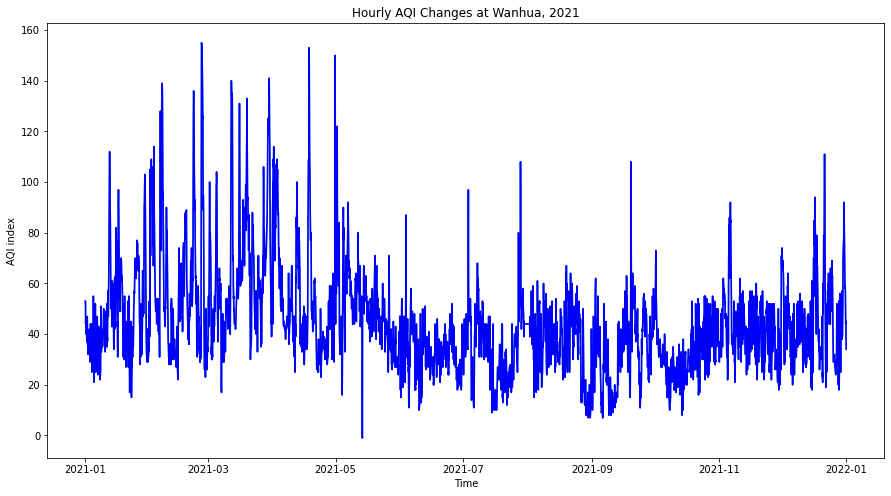

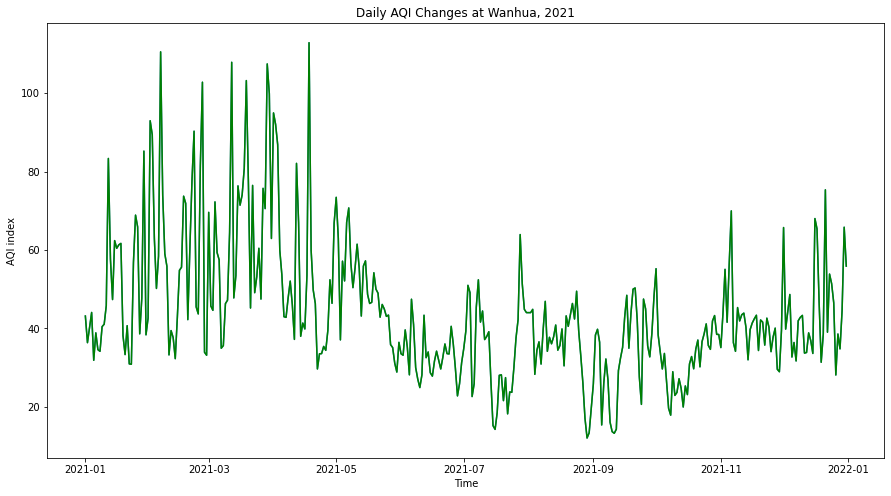

In [78]:
# visialize
Plot_Time_Series(df_Hour.Date, df_Hour[poi], "Hourly" , "blue")
Plot_Time_Series(df_Day.Date, df_Day[poi], "Daily", "green")

In [20]:
# OLS regression result
OLS_Res( "Hourly", df_Hour[poi])
OLS_Res("Daily", df_Day[poi])

Hourly OLS results: 
parameters: 
 x1    0.006879
dtype: float64

                                  OLS Regression Results                                
Dep. Variable:                    AQI   R-squared (uncentered):                   0.509
Model:                            OLS   Adj. R-squared (uncentered):              0.509
Method:                 Least Squares   F-statistic:                              9078.
Date:                Thu, 20 Jan 2022   Prob (F-statistic):                        0.00
Time:                        20:59:06   Log-Likelihood:                         -43364.
No. Observations:                8760   AIC:                                  8.673e+04
Df Residuals:                    8759   BIC:                                  8.674e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t

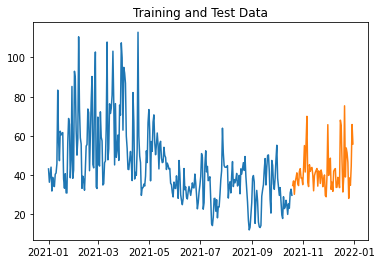

In [29]:
# split train and test dataset 
train = df_Day[:int(train_Ratio*(len(df_Day)))]
test = df_Day[int(train_Ratio*(len(df_Day))):]
plt.plot(train[poi])
plt.plot(test[poi])
plt.title("Training and Test Data")
plt.show()

In [44]:
# find optimal d
d_value = ndiffs(df_Day[poi],alpha=0.05, test='adf',max_d=1000)
print("According to ADF test, the Optimal d is : " + str(d_value))

According to ADF test, the Optimal d is : 0


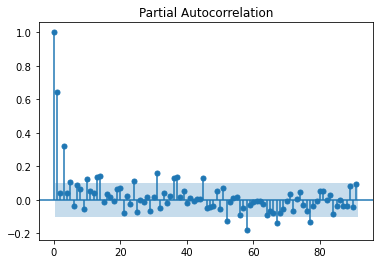

In [35]:
# Plot ACF
plot_pacf(df_Day[poi], lags = (len(df_Day)/4))
plt.show()

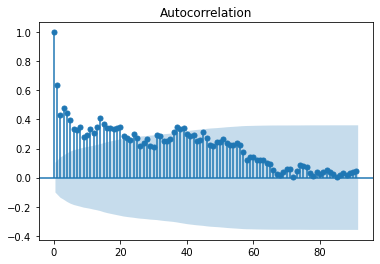

In [36]:
# Plot PACF
plot_acf(df_Day[poi], lags = (len(df_Day)/4))
plt.show()

In [46]:
# Calculate EACF
result_EACF =  EACF(train[poi], 25, 25, True)
print('\n ECAF Matrix: \n', np.around(result_EACF['eacf'], decimals=3))

AR / MA
   0  1  2  3  4  5  6  7  8  9   ... 16 17 18 19 20 21 22 23 24 25
0   x  x  x  x  x  x  x  x  x  x  ...  x  x  x  x  x  x  x  x  x  x
1   o  x  x  o  o  o  o  x  x  o  ...  o  o  o  o  o  o  o  o  o  o
2   o  x  x  o  o  o  o  o  x  o  ...  o  o  o  o  o  o  o  o  o  o
3   o  x  x  o  o  o  o  o  o  o  ...  o  o  o  o  o  o  o  o  o  o
4   x  x  o  x  o  o  o  o  o  o  ...  o  o  o  o  o  o  o  o  o  o
5   x  x  o  x  o  x  o  o  o  o  ...  o  o  o  o  o  o  o  o  o  o
6   x  x  x  o  o  o  o  o  o  o  ...  o  o  o  o  o  o  o  o  o  o
7   x  x  x  x  o  o  o  o  o  o  ...  o  o  o  o  o  o  o  o  o  o
8   x  x  x  x  o  o  o  o  o  o  ...  o  o  o  o  o  o  o  o  o  o
9   x  x  x  o  x  x  o  o  o  o  ...  o  o  o  o  o  o  o  o  o  o
10  x  o  x  x  x  o  o  o  o  o  ...  o  o  o  o  o  o  o  o  o  o
11  x  o  x  x  x  o  o  o  x  o  ...  o  o  o  o  o  o  o  o  o  o
12  x  x  o  x  x  x  x  o  x  o  ...  o  o  o  o  o  o  o  o  o  o
13  x  x  x  x  x  x  x  x  x  o  ...  o

In [51]:
# Find optimal p, q, for ARIMA model
p_value = 0
q_value = 0
aic_value = np.Inf
for p in range(0,5):
    for q in range(20,25):
        model = sm.tsa.SARIMAX(train[poi], trend='c', order=(p,d_value,q), enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=0)      
        if model_fit.aic < aic_value:           
            p_value = p       
            q_value = q
            aic_value = model_fit.aic
print("the optimal p, d, q :",str(p_value),",", str(d_value),"," , str(q_value)," and AIC value: ", str(aic_value))

the optimal p, d, q :30 24 and AIC value:  2150.620183242423


In [56]:
print("the optimal p, d, q :",str(p_value),",", str(d_value),"," , str(q_value)," and AIC value: ", str(aic_value))

the optimal p, d, q : 3 , 0 , 24  and AIC value:  2150.620183242423


In [58]:
# Fit the optimal ARIMA model
model = sm.tsa.SARIMAX(train[poi], trend='c', order=(p_value,d_value,q_value), enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=0)
model_fit.aic

2959.599347152571

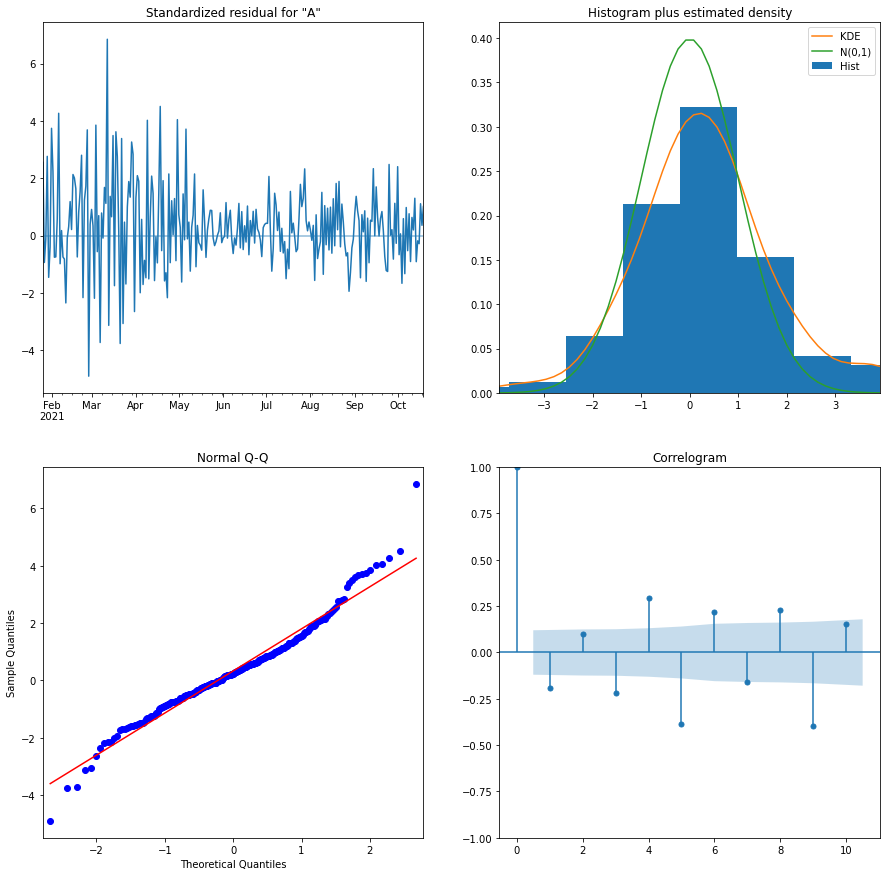

In [59]:
model_fit.plot_diagnostics(figsize = (15,15))
plt.show()

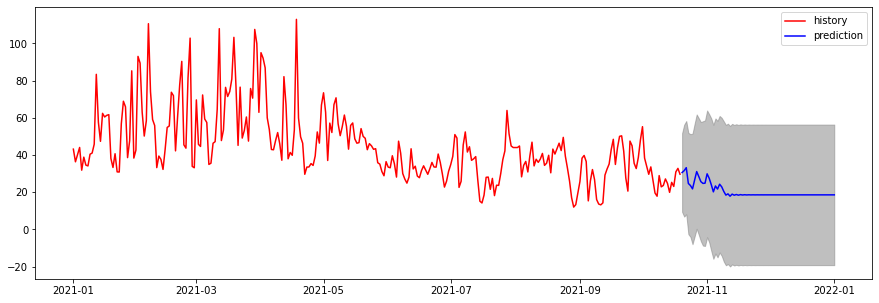

In [74]:
# find confidence interval and predictions
SARIMA_pre = model_fit.get_prediction(start=len(train), end=len(train)+len(test))
SARIMA_pre.predicted_mean

Pred_coef = SARIMA_pre.predicted_mean
Pred_coef_itv = SARIMA_pre.conf_int(alpha=0.05)

fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot()
ax.plot(train[poi], color = "red", label="history")
ax.plot(SARIMA_pre.predicted_mean, color = "blue", label="prediction")
ax.fill_between(x = Pred_coef_itv.index, y1 = Pred_coef_itv.iloc[:,0], y2 = Pred_coef_itv.iloc[:,1], color = "gray", alpha = 0.5)
ax.legend()
plt.show()


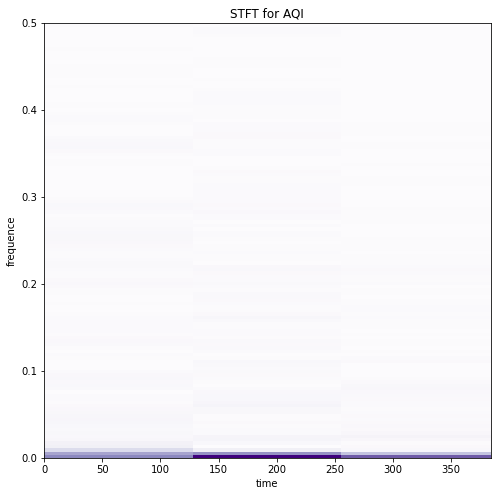

In [68]:
# STFT
STFT(df_Day[poi])

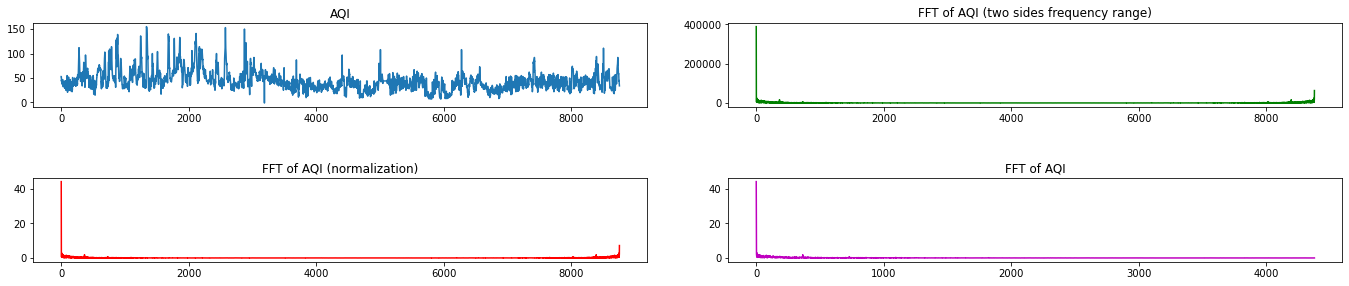

In [73]:
#FFT
FFT(df_Hour[poi])